Poisson Regression
===========

Use a generalized linear model to perform a regression on some dummy data as a test to make sure I can actually use `pymc3` for my work, if I need to.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt
from scipy import optimize

import pymc3 as pm
import theano as thno
import theano.tensor as T

import seaborn as sns

In [3]:
def plot_traces(traces, varnames=None):
    nrows = len(traces.varnames)
    if varnames is not None:
        nrows = len(varnames)
    
    ax = pm.traceplot(traces, varnames=varnames,
                      figsize=(12, nrows * 1.4),
                      lines={k: v['mean'] for k, v in
                             pm.df_summary(traces, varnames=varnames).iterrows()})
    for i, mn in enumerate(pm.df_summary(traces, varnames=varnames)['mean']):
        ax[i, 0].annotate('{:.2f}'.format(mn), xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points', rotation=90,
                          va='bottom', fontsize='large', color='#AA0022')

In [4]:
import re

def strip_derived_rvs(rvs):
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

We're going to simulate data, where we are making an assumption that sneezing increases with antihistamine use and alcohol consumption. We'll record the number of sneezes per day, and alcohol use is kept as a boolean value.

In [5]:
# decide poisson theta values
theta_noalcohol_meds = 1    # no alcohol, took an antihist
theta_alcohol_meds = 3      # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36   # alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_noalcohol_meds, q),
                                   np.random.poisson(theta_alcohol_meds, q),
                                   np.random.poisson(theta_noalcohol_nomeds, q),
                                   np.random.poisson(theta_alcohol_nomeds, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})
df.head()

,alcohol,nomeds,nsneeze
0,False,False,0
1,False,False,1
2,False,False,0
3,False,False,1
4,False,False,0


In [6]:
df.groupby(['alcohol', 'nomeds']).mean()

nsneeze
alcohol nomeds         
False   False     1.019
        True      5.945
True    False     2.974
        True     36.016

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


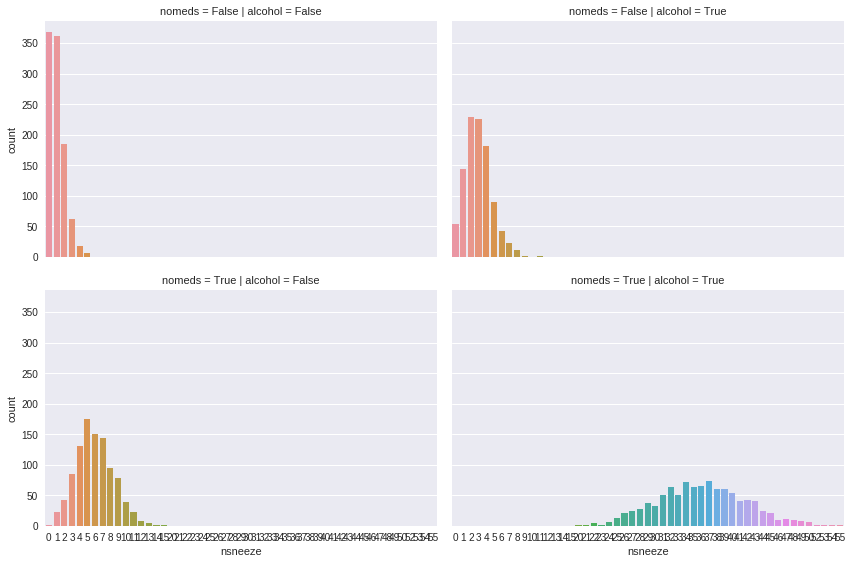

In [7]:
g = sns.factorplot(x='nsneeze', row='nomeds', col='alcohol',
                   data=df, kind='count', size=4, aspect=1.5)

Simple poisson regression model with interactions of terms:
$$ \theta = \exp(\beta X)$$
$$ Y_{\rm{sneeze count}} \rm{Poisson}(\theta)$$

In [8]:
formula = 'nsneeze ~ alcohol * nomeds'

In [10]:
# build design matrices...?

mx_en, mx_ex = pt.dmatrices(formula, df, return_type='dataframe',
                            NA_action='raise')
pd.concat([mx_ex.head(3), mx_ex.tail(3)])

,Intercept,alcohol[T.True],nomeds[T.True],alcohol[T.True]:nomeds[T.True]
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0
3999,1.0,1.0,1.0,1.0
